In [27]:
import random

In [28]:
algo_list = ["AldousBroder",
             "BacktrackingGenerator",
             "BinaryTree",
             "CellularAutomaton",
             "Division",
             "Ellers",
             "GrowingTree",
             "HuntAndKill",
             "Kruskal",
             "Prims",
             "Sidewinder",
             "TrivialMaze",
             "Wilsons"
            ]

row_size = random.randint(10, 40)
column_size = random.randint(10, 40)
algo_name = random.choice(algo_list)

In [29]:
cell_size = (row_size*2)*(column_size*2)
isSquare = False
if(row_size == column_size):
    isSquare = True

f = open("result.txt", "a")
f.write(algo_name + ",")
if(isSquare):
    f.write("Square" + ",")
else:
    f.write("Rectangle" + ",")
f.write(str(cell_size) + ",")
f.close()

In [30]:
%run ./maze_generator.ipynb

In [31]:
generate_maze(row_size, column_size, algo_name)

In [32]:
convert_to_bin()

In [33]:
clean_file()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
import networkx as nx
import queue
import random as rd
from time import perf_counter

In [2]:
# Helper functions to work with the Maze

def printBinaryMaze(mazeGrid):
    ''' Display the maze corresponding to a binary grid
        Input : 2D NumPy array with 0 and 1 as elements
        Output : Simple print of the corresponding maze
    '''
    (height, width) = mazeGrid.shape
    
    print()
    for i in range(height):
        for j in range(width):
            if mazeGrid[i,j] == 1:
                print("\u25a9", end = " ")   # use some other character if the unicode does not print properly
            elif mazeGrid[i,j] == 0:
                print(".", end = " ")
        print()
        

def showBinaryMaze(mazeGrid):
    ''' Display the maze corresponding to a binary grid
        Input : 2D NumPy array with 0 and 1 as elements
        Output : Heatmap grid of the corresponding maze
    '''
    (height, width) = mazeGrid.shape
    mazeGrid = mazeGrid * 255                # just to match standard pixel values (0 to 255) in grayscale
    
    f = plt.figure(figsize = (width,height))
    heatmap(mazeGrid, vmin = 0, vmax = 255, cmap = "Greys", cbar = False)
    
    
def showBinaryMazeProblem(mazeGrid, start, goal):
    ''' Display the maze corresponding to a binary grid
        Display "start" and "goal" position on the grid 
        Input : 2D NumPy array with 0 and 1 as elements
        Input : 2D coordinate of the "start" and "goal"
        Output : Heatmap grid of the maze with markers
    '''
    (height, width) = mazeGrid.shape
    mazeGrid = mazeGrid * 255
    
    mazeGrid[start[0], start[1]] = 128
    mazeGrid[goal[0], goal[1]] = 128
    
    f = plt.figure(figsize = (width,height))
    heatmap(mazeGrid, vmin = 0, vmax = 255, cmap = "Greys", cbar = False)

In [3]:
Data = np.genfromtxt("output.txt", dtype=int,
                     encoding=None, delimiter=",")

# print("Before")
# print(Data)
# print("After")
maze = Data[:, :-1]

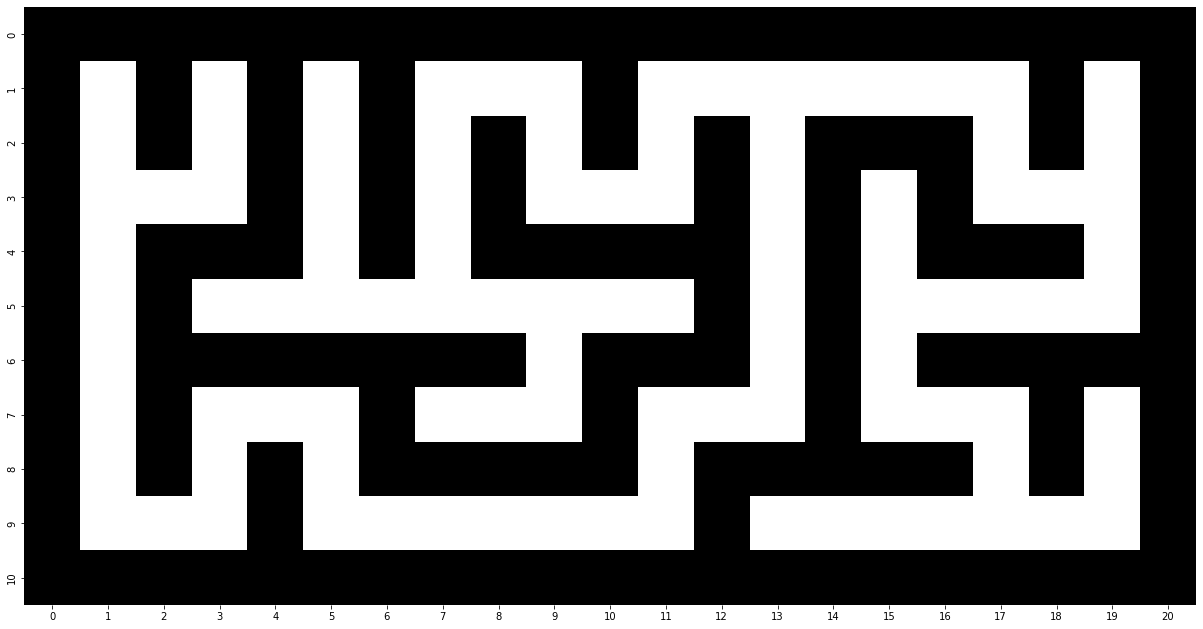

In [4]:
# Show the maze using helper functions
showBinaryMaze(maze)

In [38]:
# Create a Graph class
class MazeGraph(object):
    ''' Class to represent a Graph
        Construction : Using Edges
    '''
    def __init__(self):
        self.edges = {}
    
    def all_edges(self):
        return self.edges
    
    def neighbors(self, node):
        return self.edges[node]  

In [39]:
# Function to convert a maze to a graph
def maze_to_graph(mazeGrid):
    ''' Converts a 2D binary maze to corresponding graph
        Input : 2D NumPy array with 0 and 1 as elements
        Output : MazeGraph corresponding to input maze
    '''
    mazeGraph = MazeGraph()
    (height, width) = mazeGrid.shape
    
    for i in range(height):
        for j in range(width):
            
            # Only consider blank cells as nodes
            if mazeGrid[i,j] == 0:
                
                neighbors = []
                
                # Adjacent cell : Top
                if (i > 0) and mazeGrid[i-1,j] == 0:
                    neighbors.append(((i-1,j), 1))
                    
                # Adjacent cell : Left                
                if (j > 0) and mazeGrid[i,j-1] == 0:
                    neighbors.append(((i,j-1), 1))
                    
                # Adjacent cell : Bottom                    
                if (i < height - 1) and mazeGrid[i+1,j] == 0:
                    neighbors.append(((i+1,j), 1))

                # Adjacent cell : Right                    
                if (j < width - 1) and mazeGrid[i,j+1] == 0:
                    neighbors.append(((i,j+1), 1))

                # Insert edges in the graph
                if len(neighbors) > 0:
                    mazeGraph.edges[(i,j)] = neighbors

    return mazeGraph

In [40]:
# Convert the maze to a graph
mazegraph = maze_to_graph(maze)

# Print the edges with weights
# mazegraph.all_edges()

In [41]:
# Helper functions to work with the Maze with Path

def showBinaryMazePath(mazeGrid, mazePath):
    ''' Display the maze corresponding to a binary grid
        Display path(s) superimposed on the binary grid 
        Input : 2D NumPy array with 0 and 1 as elements
        Input : 2D coordinates of the paths on the maze
        Output : Heatmap grid of the maze with the path
    '''
    (height, width) = mazeGrid.shape
    mazeGrid = mazeGrid * 255                # just to match standard pixel values (0 to 255) in grayscale
    
    for node in mazePath:
        mazeGrid[node[0], node[1]] = 128     # half level of grayscale (0 to 255) to highlight the path
    
    f = plt.figure(figsize = (width,height))
    heatmap(mazeGrid, vmin = 0, vmax = 255, cmap = "Greys", cbar = False)

# Start and Goal Values

In [42]:
start_x, start_y = 1, 1
goal_x, goal_y = (row_size*2) - 1, (column_size*2) - 1

# BFS

In [43]:
# Breadth-First-Search (BFS) with FIFO Queue

def breadth_first_search(mazeGraph, start, goal):
    ''' Function to perform BFS to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    start_time = perf_counter()
    frontier = queue.Queue()    # FIFO Queue for Frontier
    
    # initialization
    frontier.put(start)         # Add the start node to frontier
    explored = {}               # Dict of explored nodes {node : parentNode}
    explored[start] = None      # start node has no parent node
    processed = 0               # Count of total nodes processed
    
    while not frontier.empty():
        # get next node from frontier
        currentNode = frontier.get()
        processed += 1
        
        # stop when goal is reached
        if currentNode == goal:
            break
        
        # explore every single neighbor of current node
        for nextNode, weight in mazeGraph.neighbors(currentNode):
           
            # ignore if it has already been explored
            if nextNode not in explored:
                
                # put new node in frontier
                frontier.put(nextNode)
                
                # assign current node as parent
                explored[nextNode] = currentNode
    
    end_time = perf_counter()
    runtime = end_time - start_time
    f = open("result.txt", "a")
    # f.write("BFS")
    # f.write("\n")
    runtime *= 1000
    f.write(str(np.round(runtime,2)) + ",")
    f.close()
    
    return explored, processed


# Reconstruct the path from the Dict of explored nodes {node : parentNode}
# Intuition : Backtrack from the goal node by checking successive parents

def reconstruct_path(explored, start, goal):
    currentNode = goal             # start at the goal node
    path = []                      # initiate the blank path

    # stop when backtrack reaches start node
    while currentNode != start:
        # grow the path backwards and backtrack
        path.append(currentNode)
        currentNode = explored[currentNode]

    path.append(start)             # append start node for completeness
    path.reverse()                 # reverse the path from start to goal

    return path

In [44]:
# Define start and goal positions
START = (start_x,start_y)
GOAL = (goal_x,goal_y)

# Run the BFS algorithm for path finding
nodesExplored, nodesProcessed = breadth_first_search(mazegraph, start = START, goal = GOAL)
path = reconstruct_path(nodesExplored, start = START, goal = GOAL)

# Basic measures for the algorithm
"""
print("Breadth-First-Search (BFS)")
print()
"""
totalNodes = np.count_nonzero(maze == 0)
"""
print("Total nodes in maze :", totalNodes)
print("Total nodes visited :", nodesProcessed, " | ", np.round(100*(nodesProcessed/totalNodes),2), "%")
print("Final path distance :", len(path))
print()
"""

f = open("result.txt", "a")
f.write(str(np.round(100*(nodesProcessed/totalNodes),2)) + ",")
f.close()

# Print the path and show using helper functions
"""
print("Path through the Maze :", path)
showBinaryMazePath(maze,path)
"""

'\nprint("Path through the Maze :", path)\nshowBinaryMazePath(maze,path)\n'

# DFS

In [45]:
# Depth-First-Search (DFS) with Stack

def depth_first_search(mazeGraph, start, goal):
    ''' Function to perform DFS to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    start_time = perf_counter()
    
    frontier = []               # Stack for Frontier
    
    # initialization
    frontier.append(start)       # Add the start node to frontier
    explored = {}               # Dict of explored nodes {node : parentNode}
    explored[start] = None      # start node has no parent node
    processed = 0               # Count of total nodes processed
    
    while not (len(frontier) == 0):
        # Write the entire logic for this search algorithm
        # Hint : Take note from the BFS algorithm presented above
        # get next node from frontier
        
        currentNode = frontier.pop()
        processed += 1
        
        # stop when goal is reached
        if currentNode == goal:
            break
        
        # explore every single neighbor of current node
        for nextNode, weight in mazeGraph.neighbors(currentNode):
           
            # ignore if it has already been explored
            if nextNode not in explored:
                
                # put new node in frontier
                frontier.append(nextNode)
                
                # assign current node as parent
                explored[nextNode] = currentNode
    
    end_time = perf_counter()
    runtime = end_time - start_time
    
    f = open("result.txt", "a")
    # f.write("DFS")
    # f.write("\n")
    runtime *= 1000
    f.write(str(np.round(runtime,2)) + ",")
    f.close()
    
    return explored, processed


# Reconstruct the path from the Dict of explored nodes {node : parentNode}
# Intuition : Backtrack from the goal node by checking successive parents

def reconstruct_path(explored, start, goal):
    currentNode = goal             # start at the goal node
    path = []                      # initiate the blank path

    # stop when backtrack reaches start node
    while currentNode != start:
        # grow the path backwards and backtrack
        path.append(currentNode)
        currentNode = explored[currentNode]

    path.append(start)             # append start node for completeness
    path.reverse()                 # reverse the path from start to goal

    return path

In [46]:
# Define start and goal positions
START = (start_x,start_y)
GOAL = (goal_x,goal_y)

# Run the DFS algorithm for path finding
nodesExplored, nodesProcessed = depth_first_search(mazegraph, start = START, goal = GOAL)
path = reconstruct_path(nodesExplored, start = START, goal = GOAL)

# Basic measures for the algorithm
"""
print("Depth-First-Search (DFS)")
print()
"""
totalNodes = np.count_nonzero(maze == 0)
"""
print("Total nodes in maze :", totalNodes)
print("Total nodes visited :", nodesProcessed, " | ", np.round(100*(nodesProcessed/totalNodes),2), "%")
print("Final path distance :", len(path))
print()
"""

f = open("result.txt", "a")
f.write(str(np.round(100*(nodesProcessed/totalNodes),2)) + ",")
f.close()

# Print the path and show using helper functions
"""
print("Path through the Maze :", path)
showBinaryMazePath(maze,path)
"""

'\nprint("Path through the Maze :", path)\nshowBinaryMazePath(maze,path)\n'

# UCS

In [47]:
# Uniform-Cost-Search (UCS) with Priority Queue

def uniform_cost_search(mazeGraph, start, goal):
    ''' Function to perform UCS to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    start_time = perf_counter()
    
    frontier = queue.PriorityQueue()      # Priority Queue for Frontier
    
    # initialization
    frontier.put((0, start))    # Add the start node to frontier with priority 0
    explored = {}               # Dict of explored nodes {node : parentNode}
    explored[start] = None      # start node has no parent node
    pathcost = {}               # Dict of cost from start to node
    pathcost[start] = 0         # start to start cost should be 0
    processed = 0               # Count of total nodes processed
    
    while not frontier.empty():
        # get next node from frontier
        currentNode = frontier.get()[1]
        processed += 1
        
        # stop when goal is reached
        if currentNode == goal:
            break
        
        # explore every single neighbor of current node
        for nextNode, weight in mazeGraph.neighbors(currentNode):
            
            # compute the new cost for the node based on the current node
            newcost = pathcost[currentNode] + weight

            # consider if not yet explored or if the new cost is lower 
            if (nextNode not in explored) or (newcost < pathcost[nextNode]):

                # set priority as newcost 
                priority = newcost
                
                # put new node in frontier with priority
                frontier.put((priority, nextNode))
                
                # assign current node as parent
                explored[nextNode] = currentNode
                
                # keep track of the updated path cost
                pathcost[nextNode] = newcost
    
    end_time = perf_counter()
    runtime = end_time - start_time
    
    f = open("result.txt", "a")
    # f.write("UCS")
    # f.write("\n")
    runtime *= 1000
    f.write(str(np.round(runtime,2)) + ",")
    f.close()
    
    return explored, pathcost, processed


# Reconstruct the path from the Dict of explored nodes {node : parentNode}
# Intuition : Backtrack from the goal node by checking successive parents

def reconstruct_path(explored, start, goal):
    currentNode = goal             # start at the goal node
    path = []                      # initiate the blank path

    # stop when backtrack reaches start node
    while currentNode != start:
        # grow the path backwards and backtrack
        path.append(currentNode)
        currentNode = explored[currentNode]

    path.append(start)             # append start node for completeness
    path.reverse()                 # reverse the path from start to goal

    return path

In [48]:
# Define start and goal positions
START = (start_x,start_y)
GOAL = (goal_x,goal_y)

# Run the UCS algorithm for path finding
nodesExplored, pathsExplored, nodesProcessed = uniform_cost_search(mazegraph, start = START, goal = GOAL)
path = reconstruct_path(nodesExplored, start = START, goal = GOAL)

# Basic measures for the algorithm
"""
print("Uniform-Cost-Search (UCS)")
print()
"""
totalNodes = np.count_nonzero(maze == 0)
"""
print("Total nodes in maze :", totalNodes)
print("Total nodes visited :", nodesProcessed, " | ", np.round(100*(nodesProcessed/totalNodes),2), "%")
print("Final path distance :", len(path))
print()
"""

f = open("result.txt", "a")
f.write(str(np.round(100*(nodesProcessed/totalNodes),2))+",")
f.close()

# Print the path and show using helper functions
"""
print("Path through the Maze :", path)
showBinaryMazePath(maze,path)
"""

'\nprint("Path through the Maze :", path)\nshowBinaryMazePath(maze,path)\n'

# Greedy

In [49]:
# Heuristic function for Distance

def heuristic(nodeA, nodeB):
    (xA, yA) = nodeA
    (xB, yB) = nodeB
    return abs(xA - xB) + abs(yA - yB)


# Greedy-Search (GS) with Priority Queue

def greedy_search(mazeGraph, start, goal):
    ''' Function to perform GS to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    start_time = perf_counter()
    
    frontier = queue.PriorityQueue()      # Priority Queue for Frontier
    
    # initialization
    frontier.put((0, start))    # Add the start node to frontier with priority 0
    explored = {}               # Dict of explored nodes {node : parentNode}
    explored[start] = None      # start node has no parent node
    pathcost = {}               # Dict of cost from start to node
    pathcost[start] = 0         # start to start cost should be 0
    processed = 0               # Count of total nodes processed

    
    while not frontier.empty():
        # get next node from frontier
        currentNode = frontier.get()[1]
        processed += 1
        
        # stop when goal is reached
        if currentNode == goal:
            break
        
        # explore every single neighbor of current node
        for nextNode, weight in mazeGraph.neighbors(currentNode):
            
            # computer heuristic cost of next node based of itself to goal 
            heuristic_cost = heuristic(nextNode, goal)

            # consider if not yet explored or if the heuristic cost is lower 
            if (nextNode not in explored) or (heuristic_cost < pathcost[nextNode]):

                # set priority as heuristic cost 
                priority = heuristic_cost
                
                # put new node in frontier with priority
                frontier.put((priority, nextNode))
                
                # assign current node as parent
                explored[nextNode] = currentNode
                
                # keep track of the updated path cost
                pathcost[nextNode] = heuristic_cost
                
    end_time = perf_counter()
    runtime = end_time - start_time
    
    f = open("result.txt", "a")
    # f.write("Greedy")
    # f.write("\n")
    runtime *= 1000
    f.write(str(np.round(runtime,2)) + ",")
    f.close()           

    return explored, pathcost, processed


# Reconstruct the path from the Dict of explored nodes {node : parentNode}
# Intuition : Backtrack from the goal node by checking successive parents

def reconstruct_path(explored, start, goal):
    currentNode = goal             # start at the goal node
    path = []                      # initiate the blank path

    # stop when backtrack reaches start node
    while currentNode != start:
        # grow the path backwards and backtrack
        path.append(currentNode)
        currentNode = explored[currentNode]

    path.append(start)             # append start node for completeness
    path.reverse()                 # reverse the path from start to goal

    return path

In [50]:
# Define start and goal positions
START = (start_x,start_y)
GOAL = (goal_x,goal_y)

# Run the GS algorithm for path finding
nodesExplored, pathsExplored, nodesProcessed = greedy_search(mazegraph, start = START, goal = GOAL)
path = reconstruct_path(nodesExplored, start = START, goal = GOAL)

"""
# Basic measures for the algorithm
print("Greedy-Search (GS)")
print()
"""
totalNodes = np.count_nonzero(maze == 0)
"""
print("Total nodes in maze :", totalNodes)
print("Total nodes visited :", nodesProcessed, " | ", np.round(100*(nodesProcessed/totalNodes),2), "%")
print("Final path distance :", len(path))
print()
"""

f = open("result.txt", "a")
f.write(str(np.round(100*(nodesProcessed/totalNodes),2)) + ",")
f.close()

# Print the path and show using helper functions
"""
print("Path through the Maze :", path)
showBinaryMazePath(maze,path)
"""

'\nprint("Path through the Maze :", path)\nshowBinaryMazePath(maze,path)\n'

# A*

In [51]:
# Heuristic function for Distance

def heuristic(nodeA, nodeB):
    (xA, yA) = nodeA
    (xB, yB) = nodeB
    return abs(xA - xB) + abs(yA - yB)


# A*-Search (A*S) with Priority Queue

def astar_search(mazeGraph, start, goal):
    ''' Function to perform A*S to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    start_time =  perf_counter()
    
    frontier = queue.PriorityQueue()      # Priority Queue for Frontier
    
    # initialization
    frontier.put((0, start))    # Add the start node to frontier with priority 0
    explored = {}               # Dict of explored nodes {node : parentNode}
    explored[start] = None      # start node has no parent node
    pathcost = {}               # Dict of cost from start to node
    pathcost[start] = 0         # start to start cost should be 0
    processed = 0               # Count of total nodes processed
    
    while not frontier.empty():
        # Write the entire logic for this search algorithm
        # Hint : Take note from the UCS algorithm presented above
        # get next node from frontier
        currentNode = frontier.get()[1]
        processed += 1
        
        # stop when goal is reached
        if currentNode == goal:
            break
        
        # explore every single neighbor of current node
        for nextNode, weight in mazeGraph.neighbors(currentNode):
            
            heuristic_cost = heuristic(nextNode, goal)
            
            # compute the new cost for the node based on the current node
            newcost = pathcost[currentNode] + weight

            # consider if not yet explored or if the new cost is lower 
            if (nextNode not in explored) or (newcost < pathcost[nextNode]):

                # set priority as newcost 
                priority = newcost + heuristic_cost
                
                # put new node in frontier with priority
                frontier.put((priority, nextNode))
                
                # assign current node as parent
                explored[nextNode] = currentNode
                
                # keep track of the updated path cost
                pathcost[nextNode] = newcost
    
    end_time = perf_counter()
    runtime = end_time - start_time
    
    f = open("result.txt", "a")
    # f.write("A*")
    # f.write("\n")
    runtime *= 1000
    f.write(str(np.round(runtime,2)) + ",")
    f.close() 
    
    return explored, pathcost, processed


# Reconstruct the path from the Dict of explored nodes {node : parentNode}
# Intuition : Backtrack from the goal node by checking successive parents

def reconstruct_path(explored, start, goal):
    currentNode = goal             # start at the goal node
    path = []                      # initiate the blank path

    # stop when backtrack reaches start node
    while currentNode != start:
        # grow the path backwards and backtrack
        path.append(currentNode)
        currentNode = explored[currentNode]

    path.append(start)             # append start node for completeness
    path.reverse()                 # reverse the path from start to goal

    return path

In [52]:
# Define start and goal positions
START = (start_x,start_y)
GOAL = (goal_x,goal_y)

# Run the A*S algorithm for path finding
nodesExplored, pathsExplored, nodesProcessed = astar_search(mazegraph, start = START, goal = GOAL)
path = reconstruct_path(nodesExplored, start = START, goal = GOAL)

"""
# Basic measures for the algorithm
print("A*-Search (A*S)")
print()
"""
totalNodes = np.count_nonzero(maze == 0)
"""
print("Total nodes in maze :", totalNodes)
print("Total nodes visited :", nodesProcessed, " | ", np.round(100*(nodesProcessed/totalNodes),2), "%")
print("Final path distance :", len(path))
print()
"""

f = open("result.txt", "a")
f.write(str(np.round(100*(nodesProcessed/totalNodes),2)))
f.write("\n")
f.close()

# Print the path and show using helper functions
"""
print("Path through the Maze :", path)
showBinaryMazePath(maze,path)
"""

'\nprint("Path through the Maze :", path)\nshowBinaryMazePath(maze,path)\n'